# Nucleate Boiling

Looking at the options for modelling the nucleate boiling aspect of the flow.

Currently incomplete.

https://en.wikipedia.org/wiki/Nucleate_boiling

In [25]:
import bamboo as bam
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

C:\Users\Daniel\OneDrive - University of Cambridge\Cambridge\CUSF\Github Repositories\Bamboo Repository\bamboo\circuit.py:205: RuntimeWarning: divide by zero encountered in true_divide
  return 0.425 * ( k_vf**3 * rho_vf * (rho_l - rho_v) * GRAVITY * (h_fg + 0.4 * cp_l * dT) / (mu_vf * (T_w - T_sat) * (sigma / (GRAVITY * (rho_l - rho_v)) )**0.5 ) )**0.25
<ipython-input-26-b0469b6b8237>:76: RuntimeWarning: invalid value encountered in multiply
  q_film = dT * bam.circuit.h_coolant_stable_film(k_vf = k_vf,


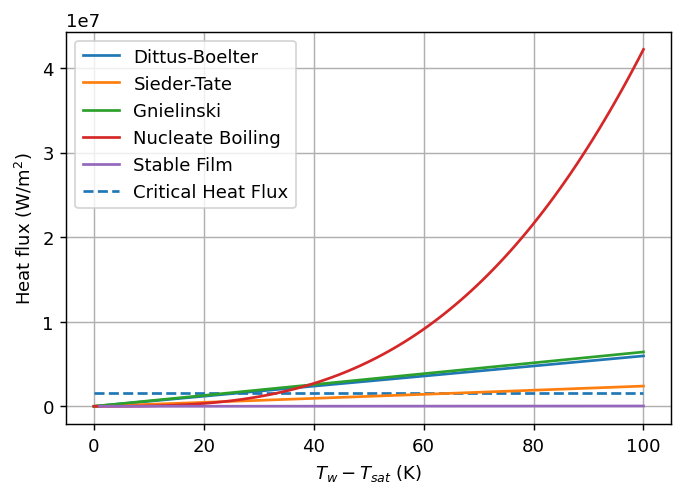

In [26]:
# Model water going through a pipe. Want to plot dQ/dA against T_wall - T_sat

# Chosen operating points
V = 10                 # Velocity, m/s
Dh = 5e-3              # Pipe hydraulci diameter, m
p = 1e5                # Fluid pressure, Pa
T_super = np.linspace(0, 100, 100)  # Temperature of wall above saturation
C_sf = 0.013           # Water/Copper

# Derived
T_sat = PropsSI("T", "P", p, "Q", 0, "WATER")
T_bulk = T_sat
T_w = T_super + T_sat
T_film = 0.5 * (T_w + T_bulk)
dT = T_w - T_bulk

rho_v = PropsSI("DMASS", "P", p, "Q", 1, "WATER")
rho_vf = PropsSI("DMASS", "Q", 1, "T", T_film, "WATER")
mu_vf = PropsSI("VISCOSITY", "Q", 1, "T", T_film, "WATER")
k_vf = PropsSI("CONDUCTIVITY", "Q", 1, "T", T_film, "WATER")

rho_l = PropsSI("DMASS", "P", p, "Q", 0, "WATER")
mu_l = PropsSI("VISCOSITY", "P", p, "Q", 0, "WATER")
cp_l = PropsSI("CPMASS", "P", p, "Q", 0, "WATER")
k_l = PropsSI("CONDUCTIVITY", "P", p, "Q", 0, "WATER")
Pr_l = PropsSI("PRANDTL", "P", p, "Q", 0, "WATER")

mu_w = PropsSI("DMASS", "P", p, "T", T_w, "WATER")

h_fg = PropsSI("HMASS", "P", p, "Q", 1, "WATER") - PropsSI("HMASS", "P", p, "Q", 0, "WATER")
sigma = PropsSI("SURFACE_TENSION", "P", p, "Q", 0, "WATER")

ReDh = rho_l * V * Dh / mu_l
f_darcy = (0.79 * np.log(ReDh) - 1.64)**(-2)   # Petukhov relation

# Get heat fluxes
q_dit_bol = dT * bam.circuit.h_coolant_dittus_boelter(rho = rho_l, 
                                                      V = V, 
                                                      D = Dh, 
                                                      mu = mu_l, 
                                                      Pr = Pr_l, 
                                                      k = k_l)

q_sid_tat = dT * bam.circuit.h_coolant_sieder_tate(rho = rho_l, 
                                                   V = V, 
                                                   D = Dh, 
                                                   mu_bulk = mu_l, 
                                                   mu_wall = mu_w, 
                                                   Pr = Pr_l, 
                                                   k = k_l)

q_gni = dT * bam.circuit.h_coolant_gnielinski(rho = rho_l, 
                                              V = V, 
                                              D = Dh, 
                                              mu = mu_l, 
                                              Pr = Pr_l, 
                                              k = k_l, 
                                              f_darcy = f_darcy)

q_nuc = bam.circuit.dQ_dA_nucleate(mu_l = mu_l, 
                                  h_fg = h_fg, 
                                  rho_l = rho_l, 
                                  rho_v = rho_v, 
                                  sigma = sigma, 
                                  cp_l = cp_l, 
                                  T_w = T_w, 
                                  T_sat = T_sat,
                                  C_sf = C_sf,
                                  Pr_l = Pr_l)

q_crit = bam.circuit.dQ_dA_nucleate_critical(h_fg = h_fg,
                                             rho_v = rho_v,
                                             sigma = sigma, 
                                             rho_l = rho_l)

q_film = dT * bam.circuit.h_coolant_stable_film(k_vf = k_vf,
                                                rho_vf = rho_vf,
                                                rho_v = rho_v,
                                                rho_l = rho_l,
                                                h_fg = h_fg,
                                                cp_l = cp_l,
                                                dT = dT,
                                                mu_vf = mu_vf,
                                                T_w = T_w,
                                                T_sat = T_sat,
                                                sigma = sigma)

plt.plot(T_super, q_dit_bol, label = "Dittus-Boelter")
plt.plot(T_super, q_sid_tat, label = "Sieder-Tate")
plt.plot(T_super, q_gni, label = "Gnielinski")
plt.plot(T_super, q_nuc, label = "Nucleate Boiling")
plt.hlines(q_crit, xmin = T_super[0], xmax = T_super[-1], label = "Critical Heat Flux", linestyle = "--")
plt.plot(T_super, q_film, label = "Stable Film")

plt.grid()
plt.xlabel(r"$T_w - T_{sat}$ (K)")
plt.ylabel(r"Heat flux (W/m$^2$)")
plt.legend()

plt.show()

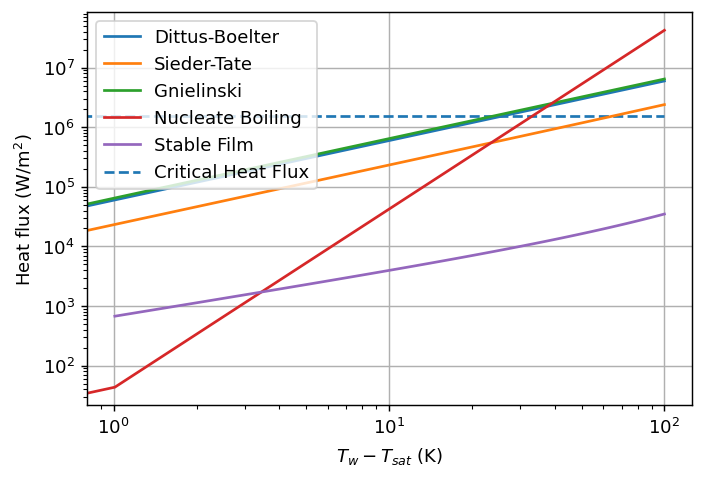

In [27]:
plt.loglog(T_super, q_dit_bol, label = "Dittus-Boelter")
plt.loglog(T_super, q_sid_tat, label = "Sieder-Tate")
plt.loglog(T_super, q_gni, label = "Gnielinski")
plt.loglog(T_super, q_nuc, label = "Nucleate Boiling")
plt.hlines(q_crit, xmin = T_super[0], xmax = T_super[-1], label = "Critical Heat Flux", linestyle = "--")
plt.loglog(T_super, q_film, label = "Stable Film")

plt.grid()
plt.xlabel(r"$T_w - T_{sat}$ (K)")
plt.ylabel(r"Heat flux (W/m$^2$)")
plt.legend()

plt.show()